In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import tensor, Tensor
import numpy as np
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

## Model

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.ct1 = nn.ConvTranspose2d(100, 128, 4, stride=2, bias = False)
        self.bn1 = nn.BatchNorm2d(128)
        self.ct2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, bias = False)
        self.bn2 = nn.BatchNorm2d(64)
        self.ct3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias = False)
        self.bn3 = nn.BatchNorm2d(32)
        self.ct4 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1, bias = False)
    
    def forward(self, x):
        x = self.bn1(self.ct1(x)).relu()
        x = self.bn2(self.ct2(x)).relu()        
        x = self.bn3(self.ct3(x)).relu()        
        x = self.ct4(x).tanh()
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.l1 = nn.Linear(3136, 512)
        self.l2 = nn.Linear(512, 1)
        self.leakyrelu = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.leakyrelu(self.conv2(x))     
        x = x.reshape(x.shape[0], -1)
        x = self.leakyrelu(self.l1(x))
        x = self.l2(x).sigmoid()
        return x

## Training

In [8]:
benchmark_noise = torch.randn(20, 100, 1, 1, requires_grad=False)

In [9]:
def criterion(x, y):
    return -(y * x.log() + (1 - y) * (1 - x).log()).mean()

In [10]:

def train_generator(discriminator, fake_data, optimizer):
    labels = torch.ones(fake_data.shape[0], device=device)
    output = discriminator(fake_data).reshape(-1)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train_discriminator(discriminator, real_data, fake_data, optimizer):
    real_output = discriminator(real_data).reshape(-1)
    fake_output = discriminator(fake_data).reshape(-1)
    real_labels = torch.ones(fake_data.shape[0], device=device)
    fake_labels = torch.zeros(fake_data.shape[0], device=device)
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    optimizer.zero_grad()
    real_loss.backward()
    fake_loss.backward()
    optimizer.step()
    return (real_loss + fake_loss).item()

In [11]:
epochs, batch_size = 70, 128
sample_interval = epochs // 4
glr, dlr = 2e-5, 3e-6
gwd, dwd = glr / epochs, dlr / epochs

In [12]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

In [13]:
generator, discriminator = Generator(), Discriminator()
generator.to(device)
discriminator.to(device)
optimizer_g = torch.optim.AdamW(generator.parameters(), lr=glr, weight_decay=gwd)
optimizer_d = torch.optim.AdamW(discriminator.parameters(), lr=dlr, weight_decay=dwd)

In [15]:
print_steps = len(trainloader) // 10
step=0

for i in range(epochs):
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        real_images = x
        fake_images = generator(torch.randn((batch_size, 100, 1, 1), device=device))
        d_loss = train_discriminator(discriminator, real_images, fake_images.detach(), optimizer_d)
        g_loss = train_generator(discriminator, fake_images, optimizer_g)
        if(step % print_steps == 0): 
            print(f"{i}:{step} g_loss {g_loss:.4f} d_loss {d_loss:.4f}")
        step+=1

0:0 g_loss 0.6883 d_loss 1.3836
0:46 g_loss 0.6717 d_loss 1.2920
0:92 g_loss 0.6880 d_loss 1.1880
0:138 g_loss 0.6592 d_loss 1.1377
0:184 g_loss 0.6262 d_loss 1.1190
0:230 g_loss 0.6632 d_loss 1.0440
0:276 g_loss 0.6748 d_loss 1.0202
0:322 g_loss 0.7417 d_loss 0.9481
0:368 g_loss 0.8446 d_loss 0.8597
0:414 g_loss 0.9174 d_loss 0.7737
0:460 g_loss 0.8340 d_loss 0.8034
1:506 g_loss 0.6836 d_loss 0.9559
1:552 g_loss 0.7705 d_loss 0.8946
1:598 g_loss 0.8179 d_loss 0.8476
1:644 g_loss 0.8432 d_loss 0.8599
1:690 g_loss 0.8783 d_loss 0.8510
1:736 g_loss 0.7983 d_loss 0.9536
1:782 g_loss 0.8560 d_loss 0.9013
1:828 g_loss 0.9260 d_loss 0.8508
1:874 g_loss 0.9809 d_loss 0.8164
1:920 g_loss 1.0397 d_loss 0.7676
2:966 g_loss 1.1395 d_loss 0.6785
2:1012 g_loss 0.6442 d_loss 1.0552
2:1058 g_loss 0.8702 d_loss 0.9457
2:1104 g_loss 0.9394 d_loss 0.8707
2:1150 g_loss 0.9775 d_loss 0.8330
2:1196 g_loss 1.0190 d_loss 0.8364
2:1242 g_loss 1.0684 d_loss 0.7576
2:1288 g_loss 1.0817 d_loss 0.7483
2:1334 g_lo

In [16]:
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')

## Inference

In [ ]:
generator = Generator()
generator.to(device);

In [ ]:
generator.load_state_dict(torch.load('generator.pt', map_location=device))

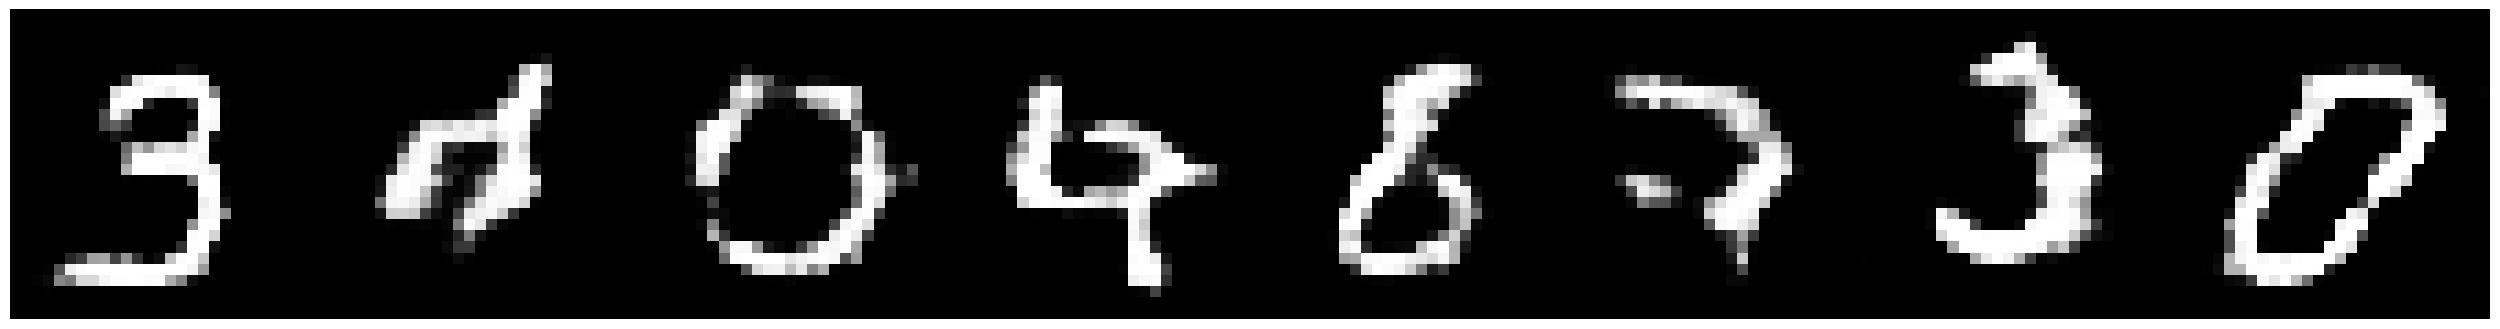

In [17]:
benchmark_noise = torch.randn(8, 100, 1, 1, requires_grad=False, device=device)
plt.figure(figsize=(32, 10))
images = generator(benchmark_noise).detach().cpu().numpy()
plt.imshow(np.hstack(images.reshape(-1, 28, 28)), cmap='gray')
plt.axis("off")
plt.show()